# Generate Spectra from a Tile

Using a tile of Gaia targets, generate STD star spectra.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.io import fits
from astropy import units as u
from astropy.table import join

from desimodel.focalplane.geometry import FocalPlane

from desisim.templates import STD

from specsim.simulator import Simulator
from specsim.source import Source

## Tile and Offset Files

Input a tile with expected positions; then input a second file with an offset field for each fiber.

In [2]:
orig_hdu = fits.open('tile-058060.fits')
orig_data = orig_hdu[1].data

proc_hdu = fits.open('tile58060_rot0.01_dithertest.fits')
proc_data = proc_hdu[1].data

# Join the offset and original tables.
rot_data = join(orig_data, proc_data, keys=['TARGETID', 'FIBER', 'LOCATION'])

# Add magnitude columns.
for band in ['G', 'R', 'Z']:
    rot_data['MAG_{}'.format(band)] = 22.5 - 2.5*np.log10(rot_data['FLUX_{}'.format(band)])

In [3]:
x, y = rot_data['DESIGN_X']*u.mm, rot_data['DESIGN_Y']*u.mm
dx, dy = rot_data['delta_x']*u.mm, rot_data['delta_y']*u.mm
flux_r = rot_data['FLUX_R']
mag_r = rot_data['MAG_R']

fp = FocalPlane()
xfp = fp.fiberpos['X'] * u.mm
yfp = fp.fiberpos['Y'] * u.mm

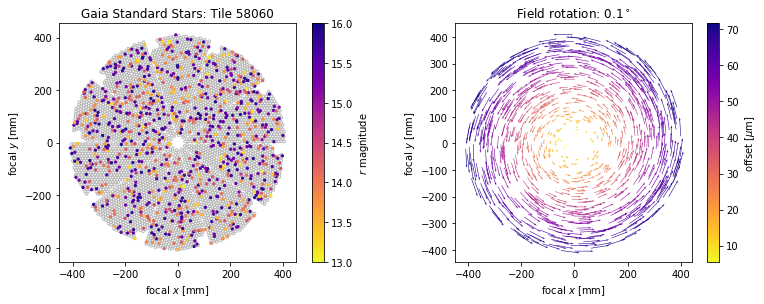

In [4]:
fig, axes = plt.subplots(1,2, figsize=(11,4.25))

ax = axes[0]
positioners = [mpl.patches.Circle((xi.value,yi.value), radius=5) for xi,yi in zip(xfp,yfp)]
positioners = mpl.collections.PatchCollection(positioners, edgecolors='#bbbbbb', facecolors='None')
ax.add_collection(positioners)

sc = ax.scatter(x, y, s=len(mag_r)*[5], c=mag_r, cmap=mpl.cm.plasma_r, vmin=13., vmax=16.)
cb = fig.colorbar(sc, ax=ax)
cb.set_label('$r$ magnitude')
ax.set(aspect='equal',
       title='Gaia Standard Stars: Tile 58060',
       xlabel='focal $x$ [mm]',
       ylabel='focal $y$ [mm]')

ax = axes[1]
q = ax.quiver(x.value, y.value, 1e3*dx.value, 1e3*dy.value, 1e3*np.sqrt(dx**2+dy**2), scale=1, units='xy',
              cmap=mpl.cm.plasma_r)
cb = fig.colorbar(q, ax=ax)
cb.set_label(r'offset [$\mu$m]')

ax.set(aspect='equal',
       xlabel='focal $x$ [mm]',
       ylabel='focal $y$ [mm]',
       title=r'Field rotation: $0.1^\circ$')

fig.tight_layout()

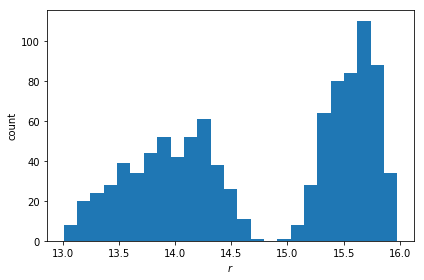

In [5]:
fig, ax = plt.subplots(1,1, figsize=(6,4))
ax.hist(mag_r, bins=25)
ax.set(xlabel='$r$',
       ylabel='count')
fig.tight_layout()

## Generate Stellar Spectra

Using a list of r magnitudes, generate a set of standard star fluxes.

In [6]:
starmaker = STD(minwave=3550., maxwave=9850.)

INFO:io.py:955:read_basis_templates: Reading /Users/sybenzvi/Documents/DESI/spectro/templates/basis_templates/v3.0/star_templates_v3.0.fits


In [7]:
nspec = len(mag_r)
flux, wave, meta, objmeta = starmaker.make_templates(mag=mag_r, nmodel=nspec, south=False,
                                                     seed=np.random.randint(1, np.iinfo(np.int32).max))

/Users/sybenzvi/anaconda/envs/desi/lib/python3.6/site-packages/speclite/filters.py:1466: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values_no_units = values_no_units[values_slice]


### Reconcile Table Data

Make sure the `TARGETID` in the output tables matches the input. Also store fiber ID, fiber xy position, and fiber RA and Dec.

In [9]:
# Update the meta and objmeta tables with valid TARGETID and other useful values.
objmeta['TARGETID'] = rot_data['TARGETID']

meta['TARGETID'] = rot_data['TARGETID']
meta['FIBER'] = rot_data['FIBER']
meta['DESIGN_X'] = x
meta['DESIGN_Y'] = y
meta['FOCAL_X'] = x + dx
meta['FOCAL_Y'] = y + dy
meta['TARGET_RA'] = rot_data['TARGET_RA'] * u.degree
meta['TARGET_DEC'] = rot_data['TARGET_DEC'] * u.degree

### Plot Fluxes

Grab a random set of fibers and plot the target fluxes generated for each.

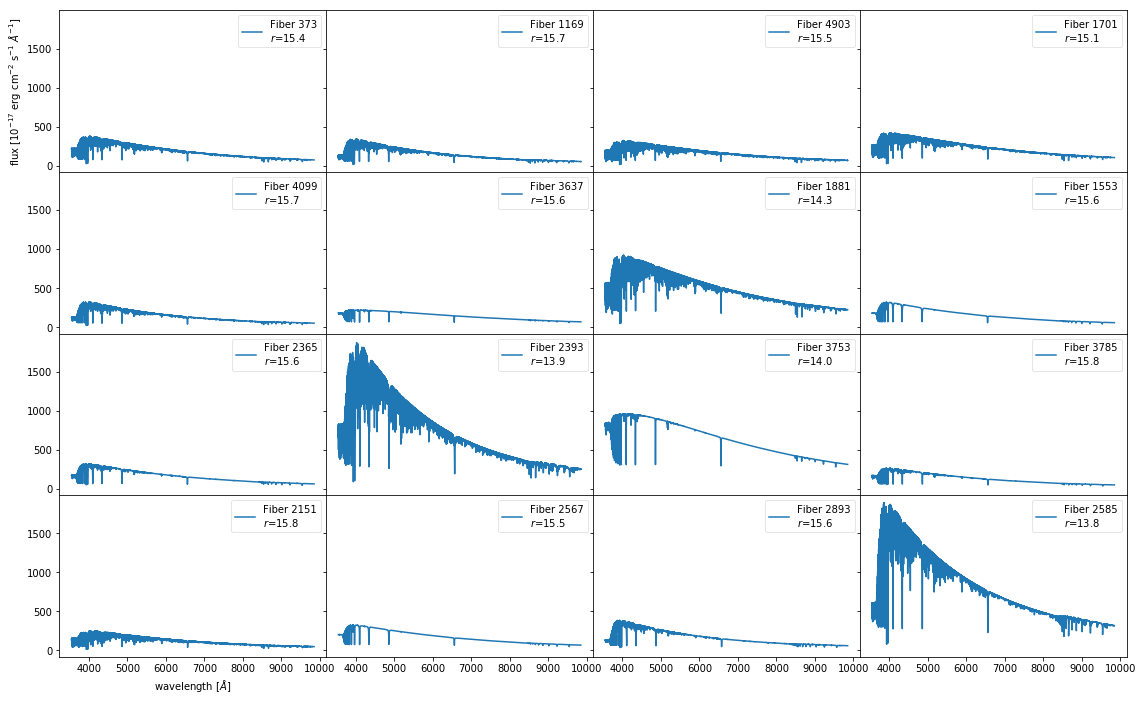

In [10]:
fig, axes = plt.subplots(4,4, figsize=(16,10), sharex=True, sharey=True)
axes = axes.flatten()
idx = sorted(np.random.choice(len(x), 16))

for i, j in enumerate(idx):
    ax = axes[i]
    
    r = meta['MAG'][j]
    ax.plot(wave, flux[j], label='Fiber {}\n$r$={:.1f}'.format(meta['FIBER'][j], meta['MAG'][j]))
    ax.legend(framealpha=0.5)
    
    if i == 0:
        ax.set(ylabel=r'flux [$10^{-17}$ erg cm$^{-2}$ s$^{-1}$ $\AA^{-1}$]')
    if i == 12:
        ax.set(xlabel=r'wavelength [$\AA$]')

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)

## Output to FITS

Output data to a FITS file for future use.

In [12]:
hx = fits.HDUList()

# Wavelength table.
hdu_wave = fits.PrimaryHDU(wave)
hdu_wave.header['EXTNAME'] = 'WAVE'
hdu_wave.header['BUNIT'] = 'Angstrom'
hdu_wave.header['AIRORVAC'] = ('vac', 'Vacuum wavelengths')
hx.append(hdu_wave)

# Flux table.
fluxunits = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom)
hdu_flux = fits.ImageHDU(flux)
hdu_flux.header['EXTNAME'] = 'FLUX'
hdu_flux.header['BUNIT'] = str(fluxunits)
hx.append(hdu_flux)

# Meta and object meta tables.
hdu_meta = fits.table_to_hdu(meta)
hdu_meta.header['EXTNAME'] = 'META'
hx.append(hdu_meta)

hdu_objmeta = fits.table_to_hdu(objmeta)
hdu_objmeta.header['EXTNAME'] = 'OBJMETA'
hx.append(hdu_objmeta)

# Write to output.
hx.writeto('tile-058060_field_rotation.fits', overwrite=True)